In [104]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [105]:
# read in all the words
words = open('../../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [106]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [107]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

# import random
# random.seed(42)
# random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(["cab"])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([4, 3]) torch.Size([4])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [108]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((5, 2), generator=g)
W1 = torch.randn((6, 10), generator=g)
#b1 = torch.randn(10, generator=g)
W2 = torch.randn((10, 5), generator=g)
#b2 = torch.randn(5, generator=g)
parameters = [C, W1, W2]
for p in parameters:
  p.requires_grad = True

In [109]:
lri = []
lossi = []
stepi = []

In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def draw_hist(weights):
    # Check if weights is a PyTorch tensor and requires gradient
    if hasattr(weights, 'requires_grad') and weights.requires_grad:
        weights = weights.detach().numpy()
    elif isinstance(weights, np.ndarray):  # If it's already a numpy array
        pass
    else:
        raise ValueError("Unsupported data type for heatmap")
    
    # Plotting the heatmap for the transposed weight matrix
    plt.figure(figsize=(15, 3))
    sns.heatmap(weights, cmap='viridis', annot=True, fmt=".2f")
    plt.title('Heatmap of the Transposed Weights')

    # Move x-axis labels to the top
    plt.gca().xaxis.tick_top()
    plt.gca().xaxis.set_label_position('top')

    plt.show()


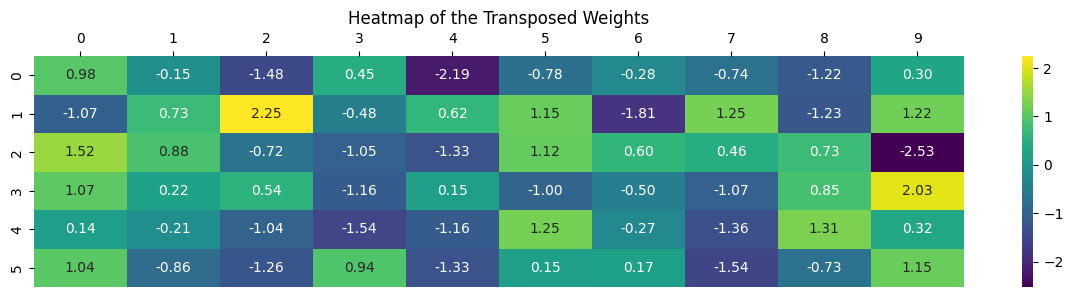

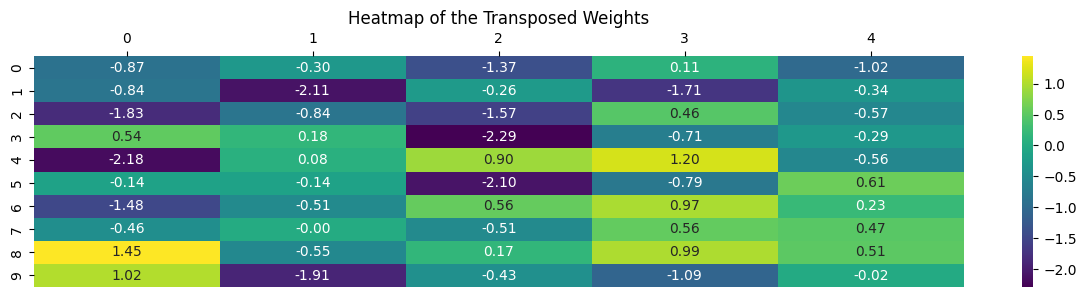

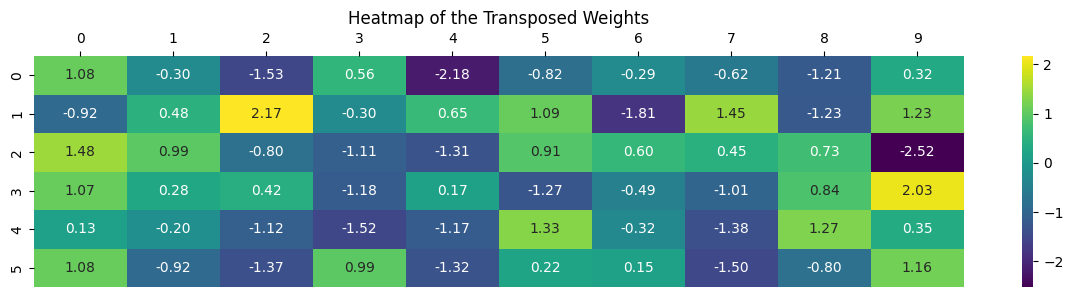

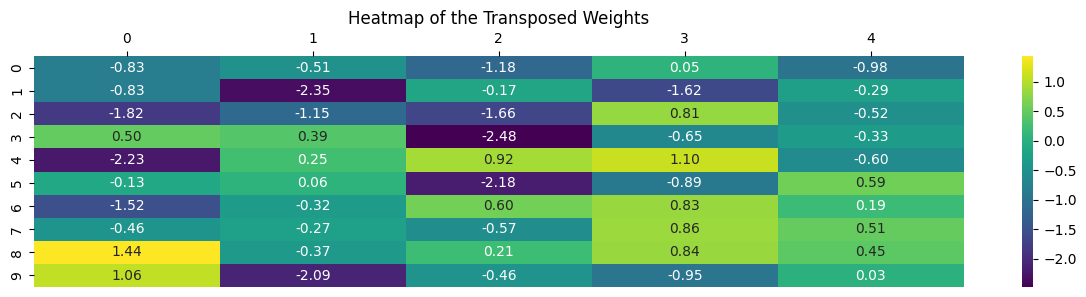

In [111]:
draw_hist(W1)
draw_hist(W2)
for i in range(100):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 6) @ W1) # (32, 200)
  logits = h @ W2  # (32, 27)
  loss = F.cross_entropy(logits, Ytr)
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

draw_hist(W1)
draw_hist(W2)

In [112]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      #print(emb.view(-1, 6)) 
      # [[-0.7575, -1.8028, -0.7575, -1.8028, -0.7575, -1.8028]]
      h = torch.tanh(emb.view(1, -1) @ W1)
      #print(h)
      # [[-0.9993, -0.7611,  0.8125,  0.9946,  0.9959, -0.8602,  0.9990,  0.9961, 0.9504, -1.0000]]
      logits = h @ W2
      print(logits)
      # [[-1.9044,  1.4295,  0.8867,  6.9308,  0.3589]]
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      #print([itos[char] for char in context])

      print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]
    
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

tensor([[-4.1044,  1.7711,  0.8090,  5.7085,  0.1311]], grad_fn=<MmBackward0>)
... ---> c
tensor([[1.0960, 6.2610, 1.4690, 2.1387, 1.4644]], grad_fn=<MmBackward0>)
..c ---> a
tensor([[-2.3542,  0.8986,  6.9640,  2.5405, -0.8215]], grad_fn=<MmBackward0>)
.ca ---> b
tensor([[ 6.7726,  0.8457, -0.1016, -2.5827,  1.1086]], grad_fn=<MmBackward0>)
cab ---> .
cab.


In [113]:
W1

tensor([[ 1.0773, -0.2987, -1.5285,  0.5567, -2.1765, -0.8195, -0.2918, -0.6202,
         -1.2144,  0.3160],
        [-0.9187,  0.4776,  2.1690, -0.2961,  0.6467,  1.0861, -1.8084,  1.4499,
         -1.2266,  1.2271],
        [ 1.4791,  0.9875, -0.7978, -1.1132, -1.3145,  0.9068,  0.5965,  0.4515,
          0.7251, -2.5211],
        [ 1.0716,  0.2763,  0.4214, -1.1777,  0.1694, -1.2723, -0.4901, -1.0148,
          0.8356,  2.0286],
        [ 0.1341, -0.2001, -1.1161, -1.5245, -1.1698,  1.3260, -0.3225, -1.3788,
          1.2710,  0.3535],
        [ 1.0763, -0.9194, -1.3692,  0.9950, -1.3247,  0.2163,  0.1468, -1.5029,
         -0.7961,  1.1623]], requires_grad=True)